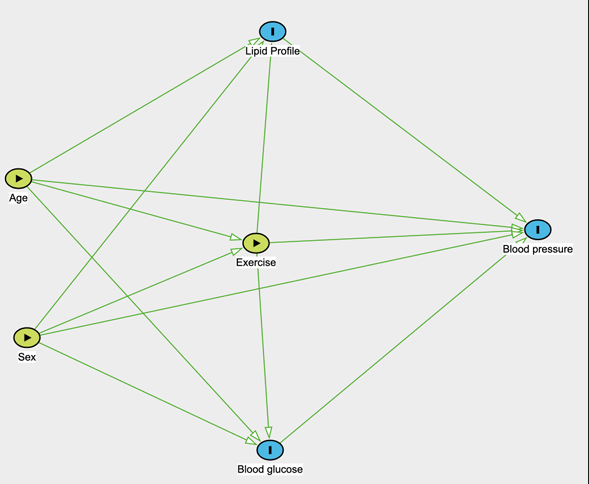

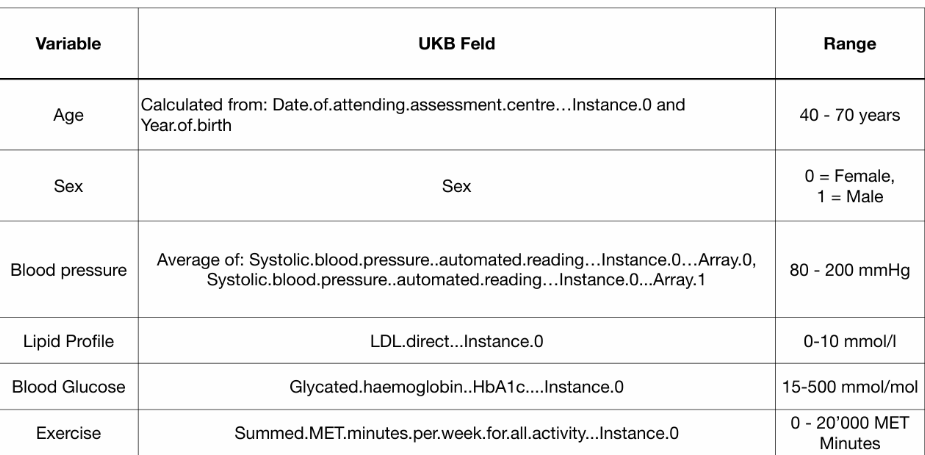

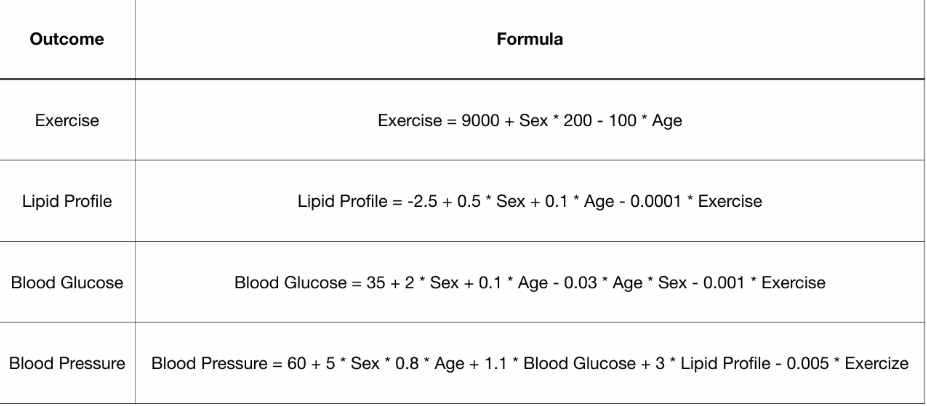

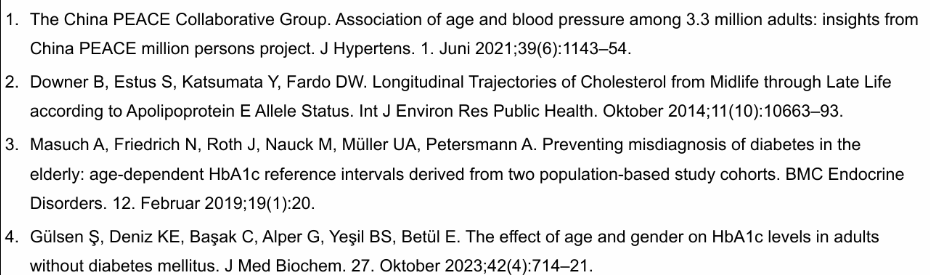

In [1]:
from tramdag import TramDagConfig, TramDagModel
import numpy as np
import pandas as pd

In [2]:
ukb_subset=pd.read_csv("/home/bule/TramDag/UKB_subset_jd_oct25.csv")

In [3]:


def simulate_dag(n_obs=1000, doX=None, seed=None):
    """
    Simulate data according to the DAG 'Effect of exercise on CVRF'
    with optional interventions (do-operations).

    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : dict or None
        Optional interventions, e.g. {'sex':1, 'exercise':10000}.
        Fixes variables to constants before propagation.
    seed : int or None
        Random seed.

    Returns
    -------
    pd.DataFrame
        Simulated dataset.
    """
    if seed is not None:
        np.random.seed(seed)

    if doX is None:
        doX = {}

    # --- 1. exogenous variables ---
    
    #  age
    # age = np.full(n_obs, doX['age']) if 'age' in doX else np.random.uniform(40, 70, n_obs)
    age = ukb_subset['age'].sample(n=n_obs, replace=True).to_numpy() # direct sampling from empirical distribution
    
    p=0.4560347936270125                                               # proportion form empirical distribution
    sex = np.full(n_obs, doX['sex']) if 'sex' in doX else np.random.binomial(1, p, n_obs)

    #exercise 
    if 'exercise' in doX:
        exercise = np.full(n_obs, doX['exercise'])
    else:
        exercise = 9000 + 200 * sex - 100 * age + np.random.normal(0, 800, n_obs)
        # exercise = np.clip(exercise, 0, 20000)

    # lipid profile 
    if 'lipid' in doX:
        lipid = np.full(n_obs, doX['lipid'])
    else:
        lipid = -2.5 + 0.5 * sex + 0.1 * age - 0.0001 * exercise + np.random.normal(0, 0.3, n_obs)
        # lipid = np.clip(lipid, 0, 10)

    # blood glucose 
    if 'glucose' in doX:
        glucose = np.full(n_obs, doX['glucose'])
    else:
        glucose = 35 + 2 * sex + 0.1 * age - 0.03 * age * sex - 0.001 * exercise + np.random.normal(0, 10, n_obs)
        # glucose = np.clip(glucose, 15, 500)

    # blood pressure 
    if 'bp' in doX:
        bp = np.full(n_obs, doX['bp'])
    else:
        bp = 60 + 5 * sex * 0.8 * age + 1.1 * glucose + 3 * lipid - 0.005 * exercise + np.random.normal(0, 5, n_obs)
        # bp = np.clip(bp, 80, 200)

    return pd.DataFrame({
        'age': age,
        'sex': sex,
        'exercise': exercise,
        'lipid': lipid,
        'glucose': glucose,
        'bp': bp
    })



In [4]:
import seaborn as sns
from sklearn.model_selection import train_test_split

df_simulated = simulate_dag(100_000, doX=None, seed=42)
print(df_simulated.head())

    age  sex     exercise     lipid    glucose          bp
0  58.0    1  3028.008608  4.291094  36.772000  323.404220
1  64.0    0  3439.892992  3.849884  41.310942   95.291730
2  70.0    0  1329.022020  4.186860  32.830610  105.465780
3  70.0    1  3200.247266  4.498705  28.519352  373.942297
4  52.0    1  4149.443127  2.530205  42.139109  296.248096


In [5]:
train_df, temp_df = train_test_split(df_simulated, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
import os
from tramdag import TramDagModel, TramDagConfig

In [7]:
cfg=TramDagConfig()
cfg.setup_configuration(EXPERIMENT_DIR='ukb', experiment_name='ukb') # works also without arguments, then default paths are used

Configuration already exists: ukb/configuration.json


In [8]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'age':'continous',
            'sex':'ordinal_Xn_Yo', 
            'exercise':'continous',
            'lipid':'continous',
            'glucose':'continous',
            'bp':'continous'} 

cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
age                  | continous       | continuous [c]                 | continuous [c]                
sex                  | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
exercise             | continous       | continuous [c]                 | continuous [c]                
lipid                | continous       | continuous [c]                 | continuous [c]                
glucose              | continous       | continuous [c]                 | continuous [c]                
bp                   | continous       | continuous [c]  

/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


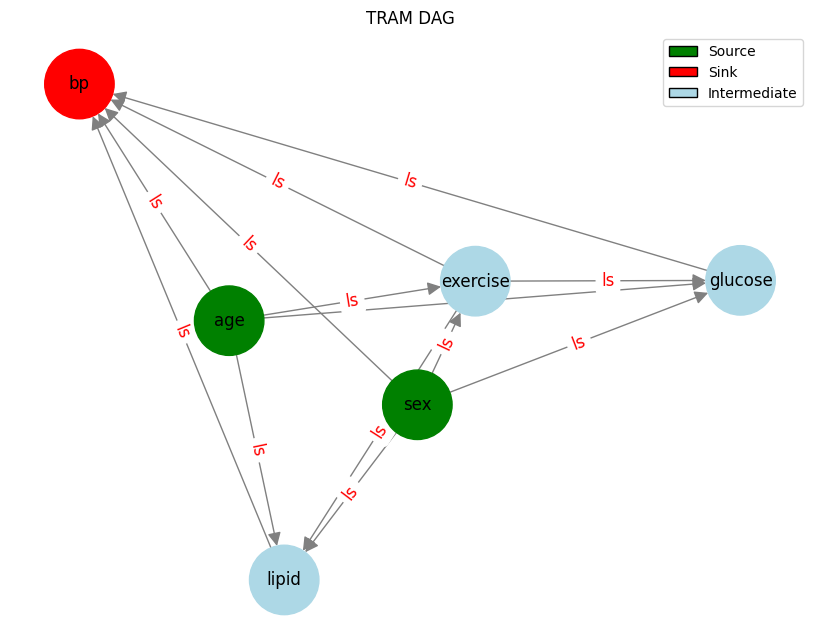

In [9]:
cfg.set_meta_adj_matrix(seed=12) #Create the (Meta) Adjacency Matrix

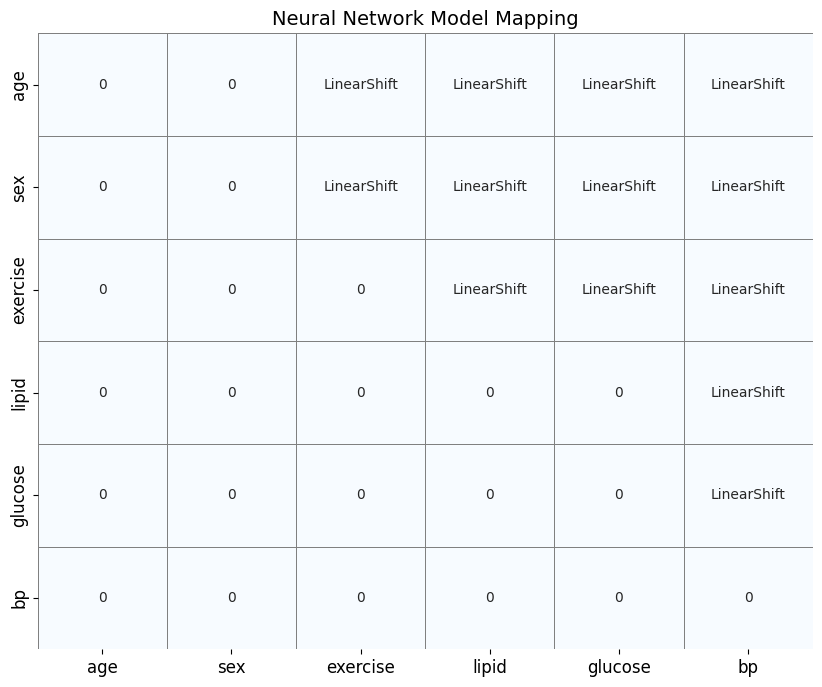

In [10]:
cfg.set_tramdag_nn_models() 


In [11]:
cfg = TramDagConfig.load_json('ukb/configuration.json')
cfg.compute_levels(df=train_df)

device='cpu'
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data =train_df )


## Fit

In [12]:
epochs = 1000

td_model.fit(train_df, val_df,
            #  train_list=['y'], #Training only on a subset of the model
             learning_rate=1e-2,
             epochs=epochs,batch_size=10_00,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,       #For DataLoader
             train_mode = "sequential") #Parallel is better for many nodes

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to ukb/min_max_scaling.json
[INFO] Training 6 nodes (sequential) on cpu

[INFO] Training node 'age' for 1000 epochs on cpu (pid=1422596)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'sex' for 1000 epochs on cpu (pid=1422596)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'exercise' for 1000 epochs on cpu (pid=1422596)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'lipid' for 1000 epochs on cpu (pid=1422596)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'glucose' for 1000 epochs on cpu (pid=1422596)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'bp' for 1000 epochs on cpu (pid=1422596)
[INFO] Existing model found. Loading weights and history from LA

## Fit diagnostics

[INFO] Loaded training/validation histories for 6 nodes.


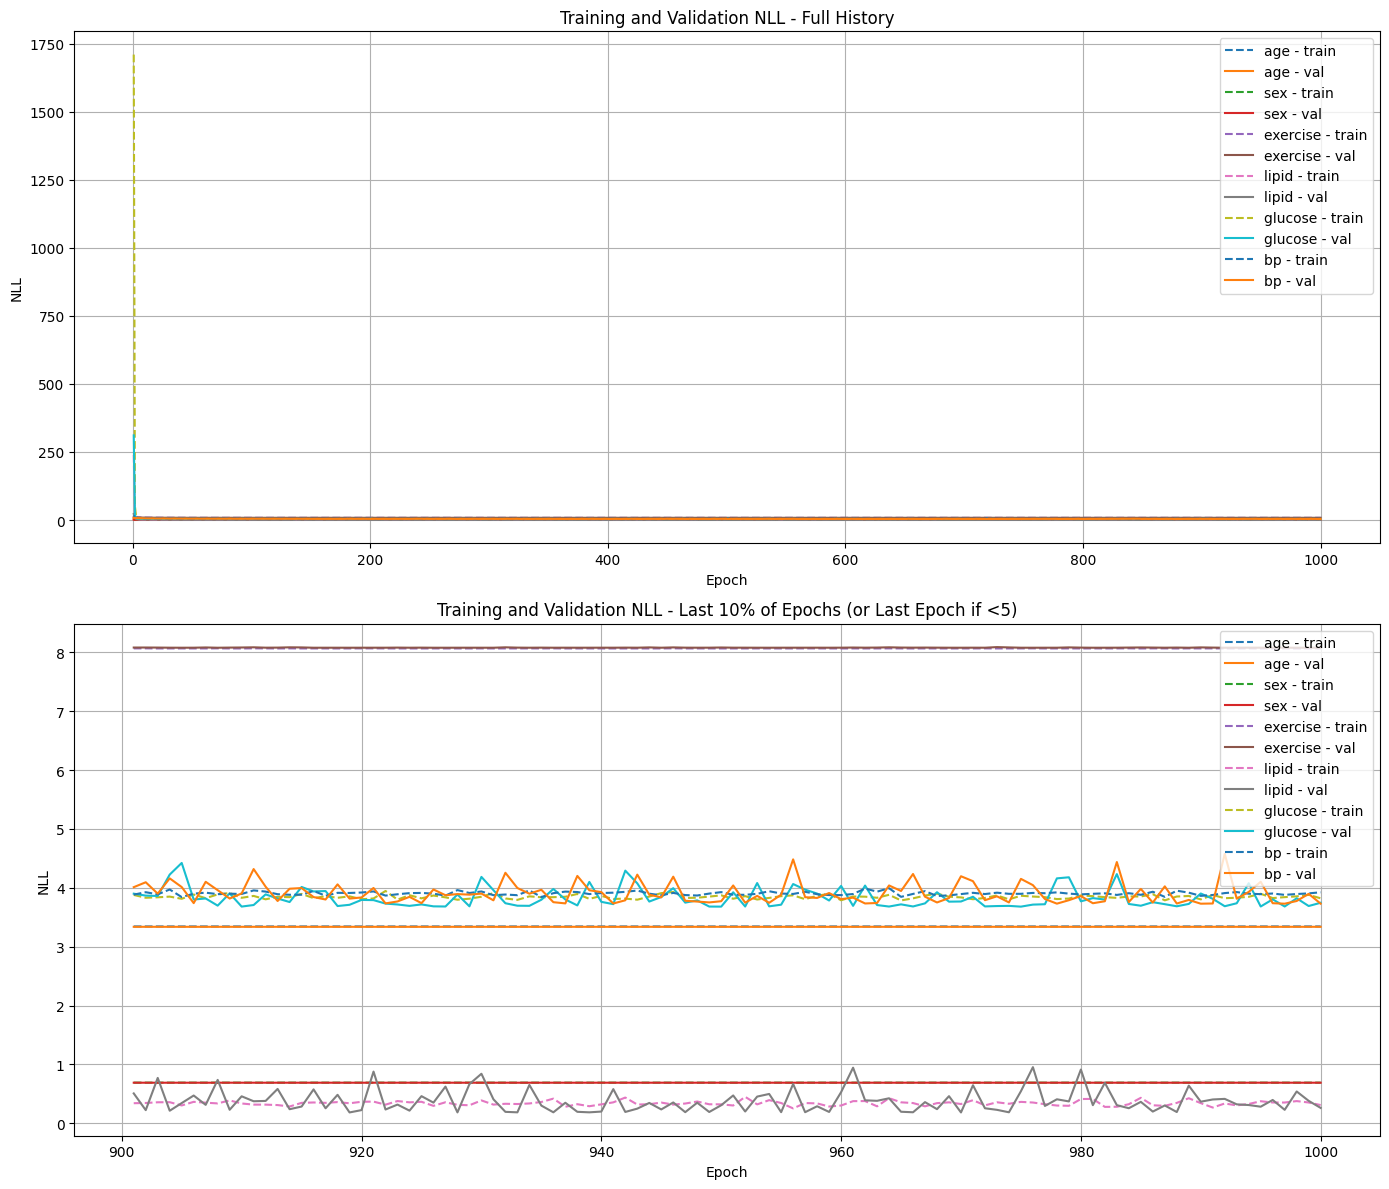

In [13]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'age' at ukb/age/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'sex' at ukb/sex/linear_shifts_all_epochs.json


/home/bule/TramDag/tramdag/TramDagModel.py:947: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(flatten)


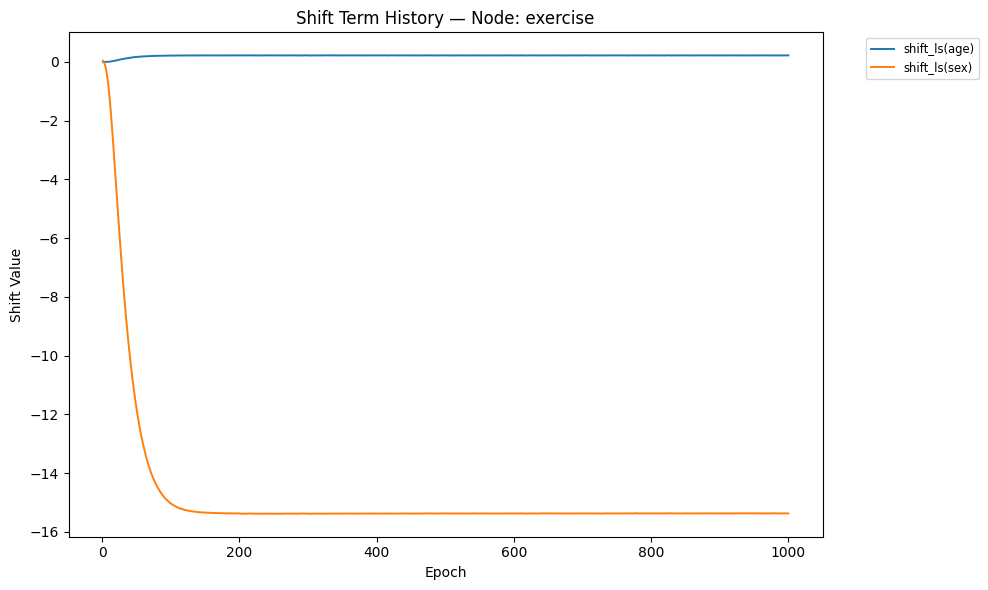

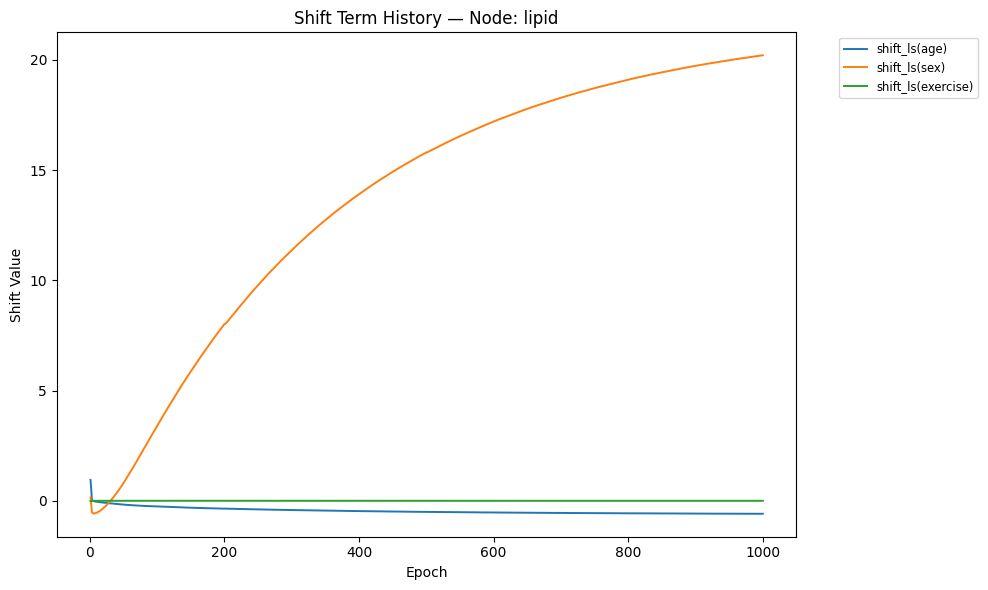

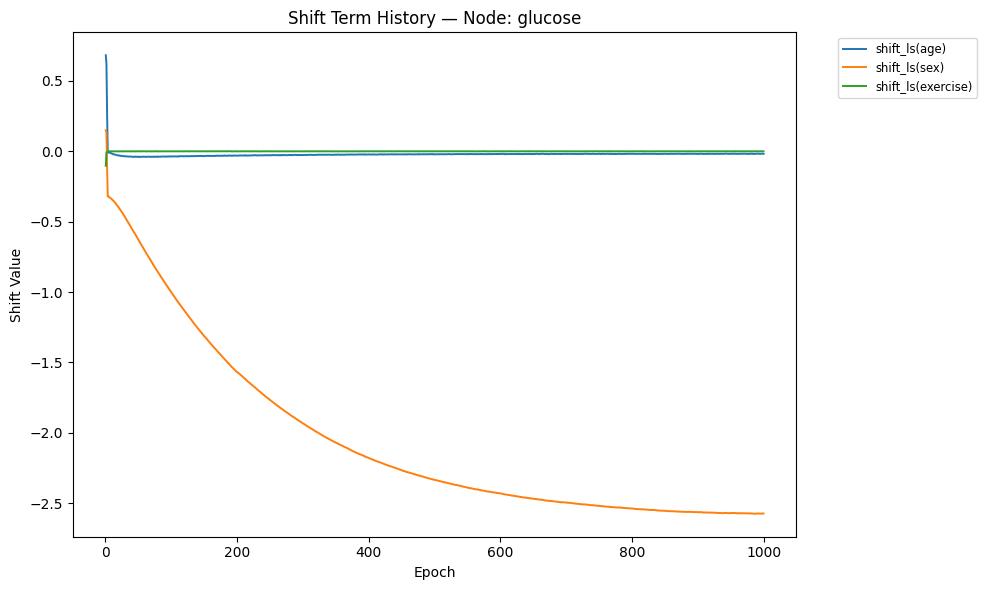

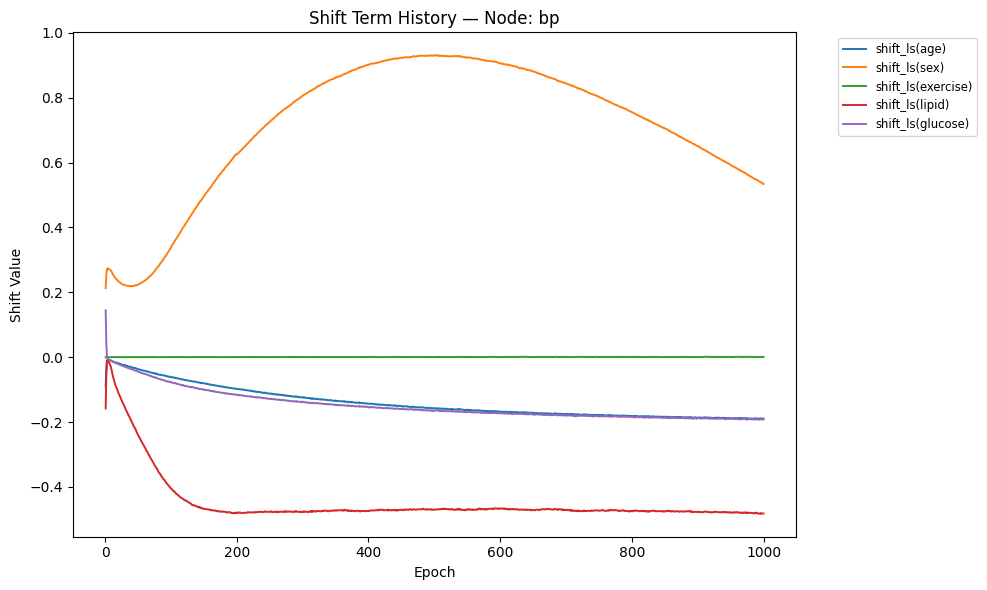

In [14]:
td_model.plot_linear_shift_history()

[INFO] Skipping node 'sex' (ordinal targets not yet supported).
[INFO] Final latent DataFrame shape: (80000, 10)


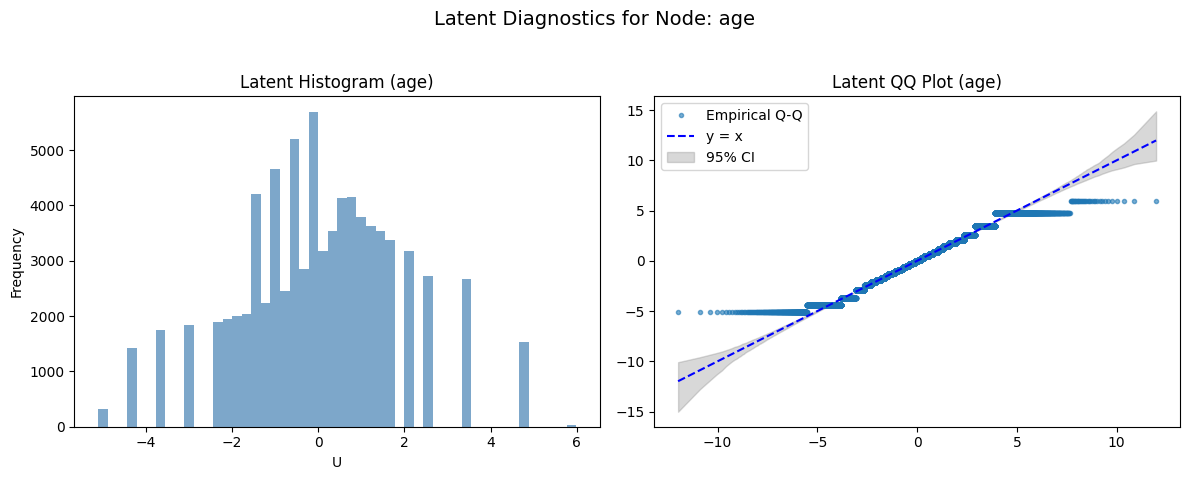

[WARNING] No latent found for node sex, skipping.


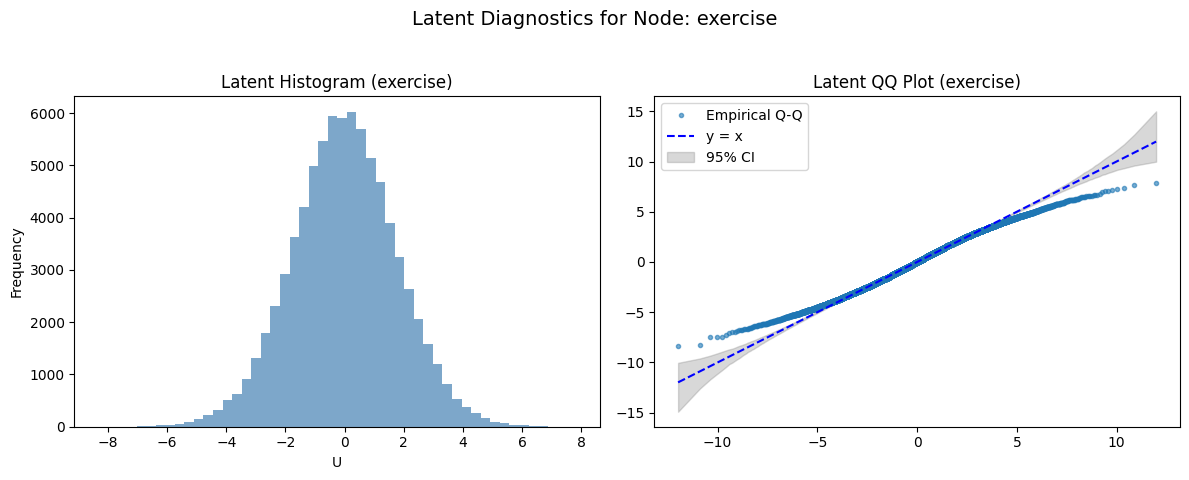

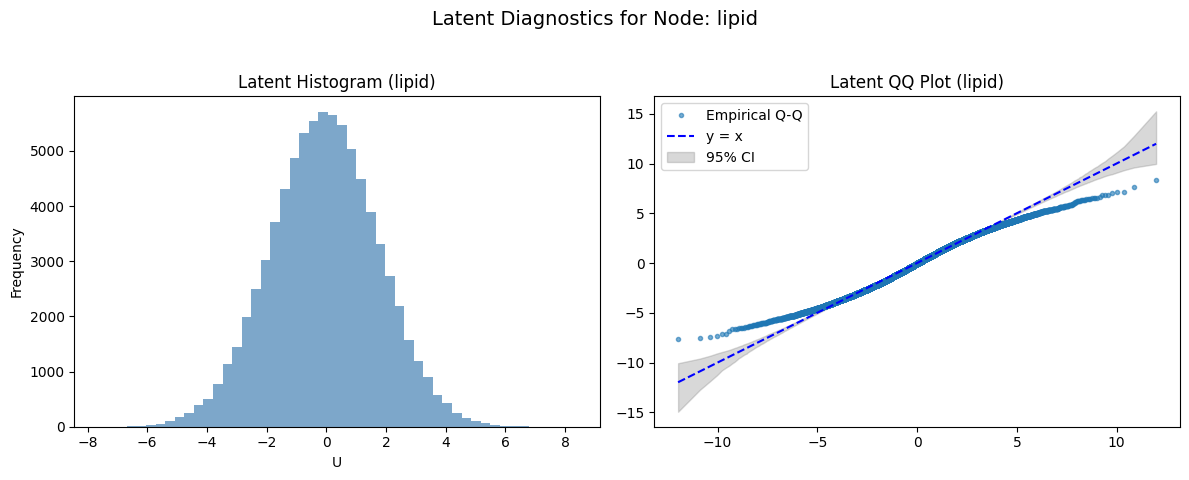

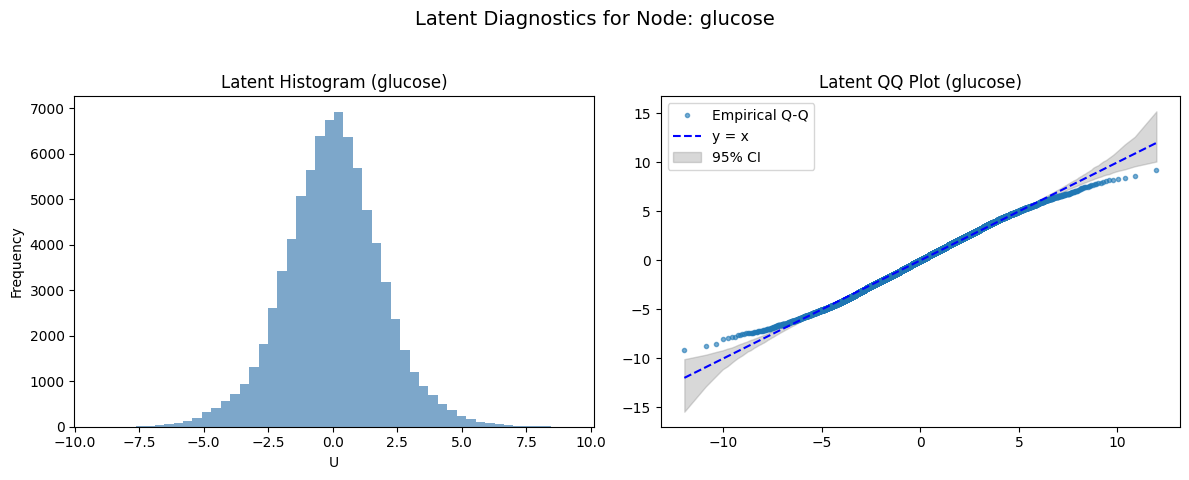

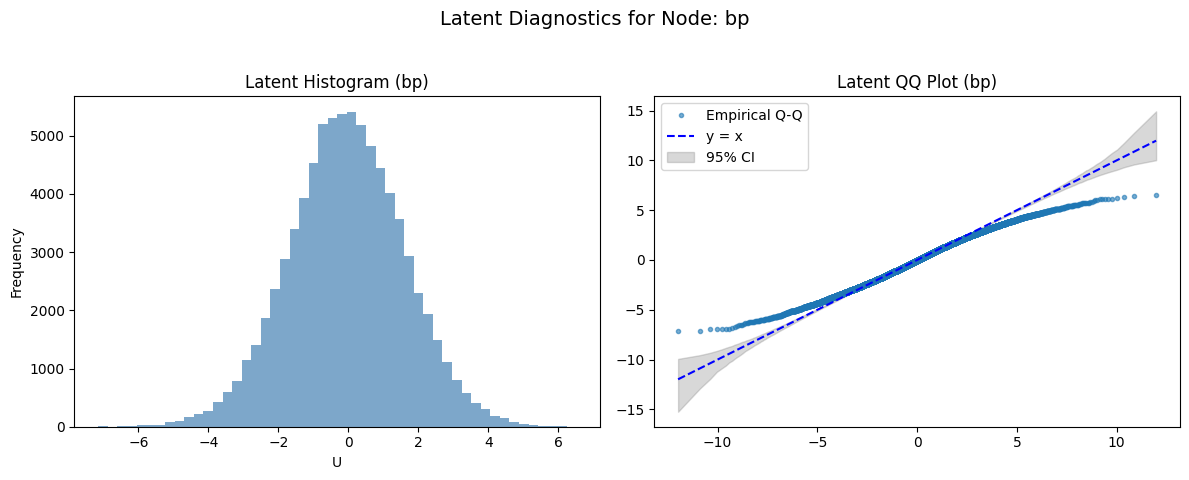

In [15]:
td_model.plot_latents(train_df)

/home/bule/TramDag/tramdag/TramDagModel.py:1000: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


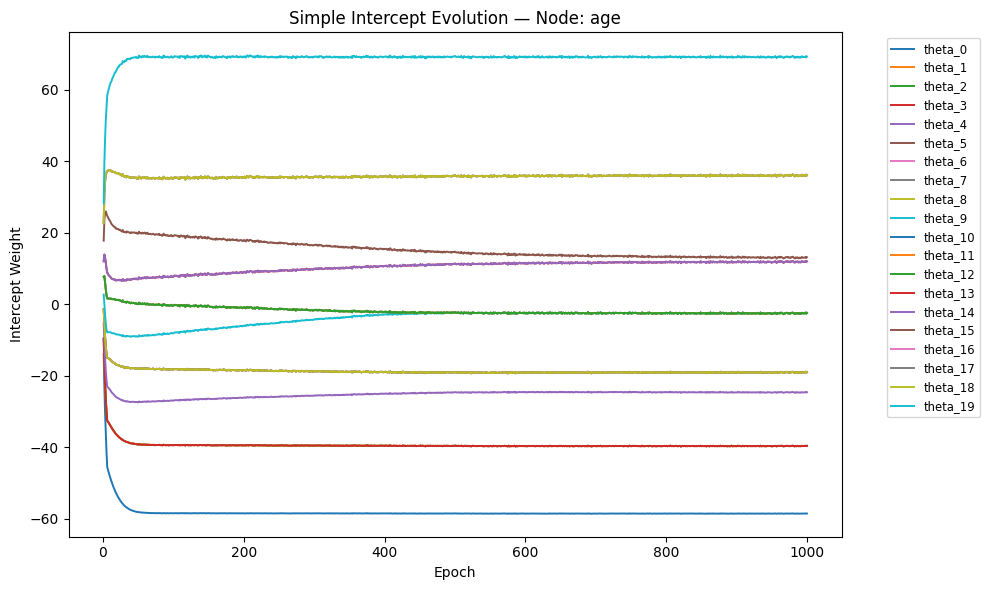

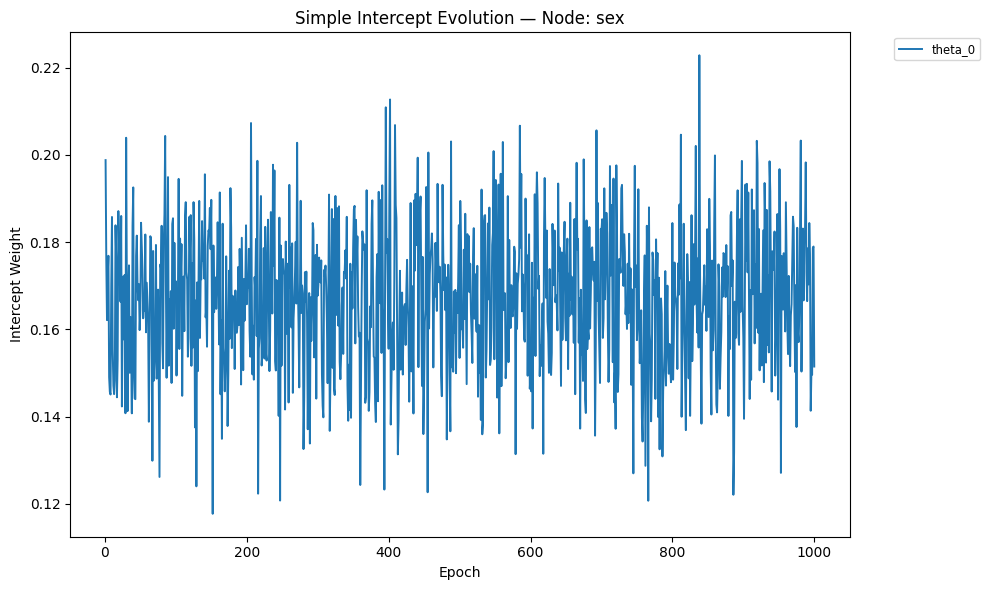

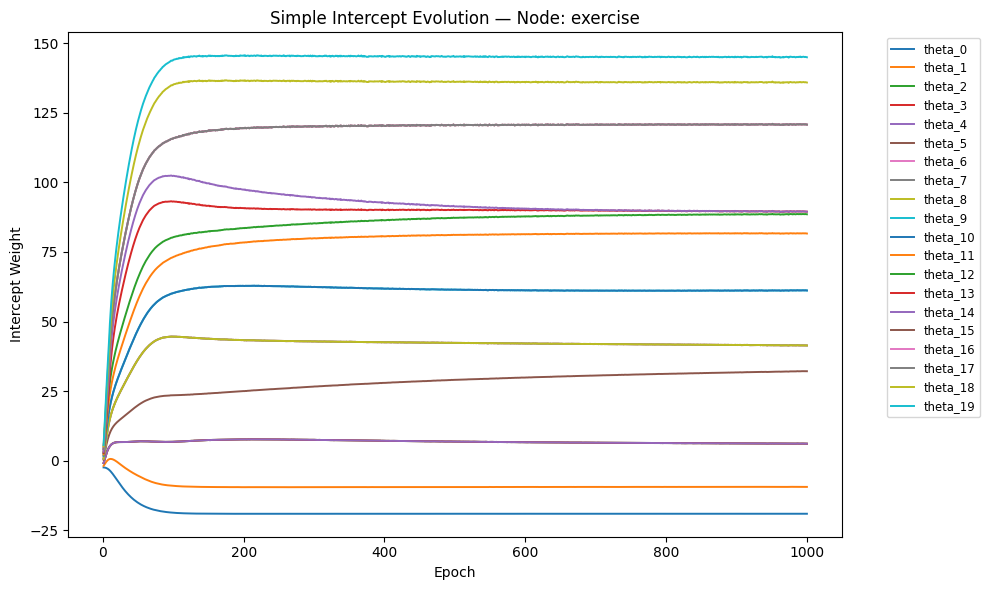

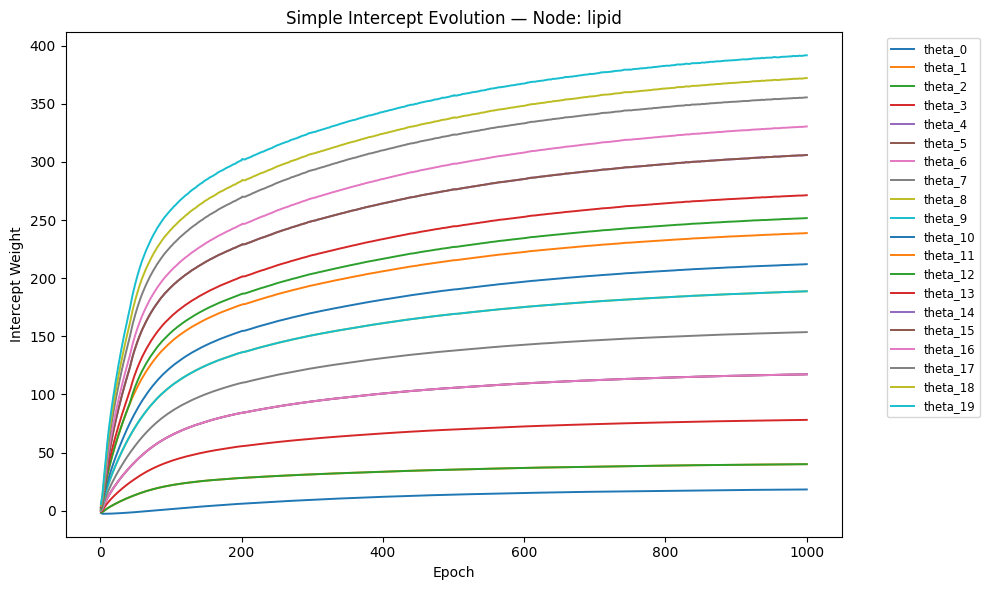

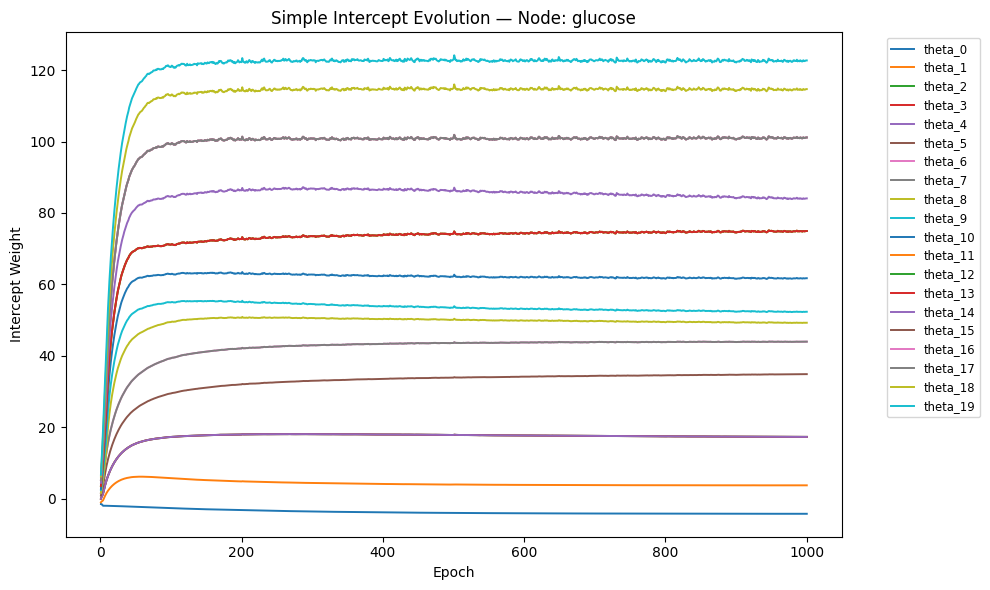

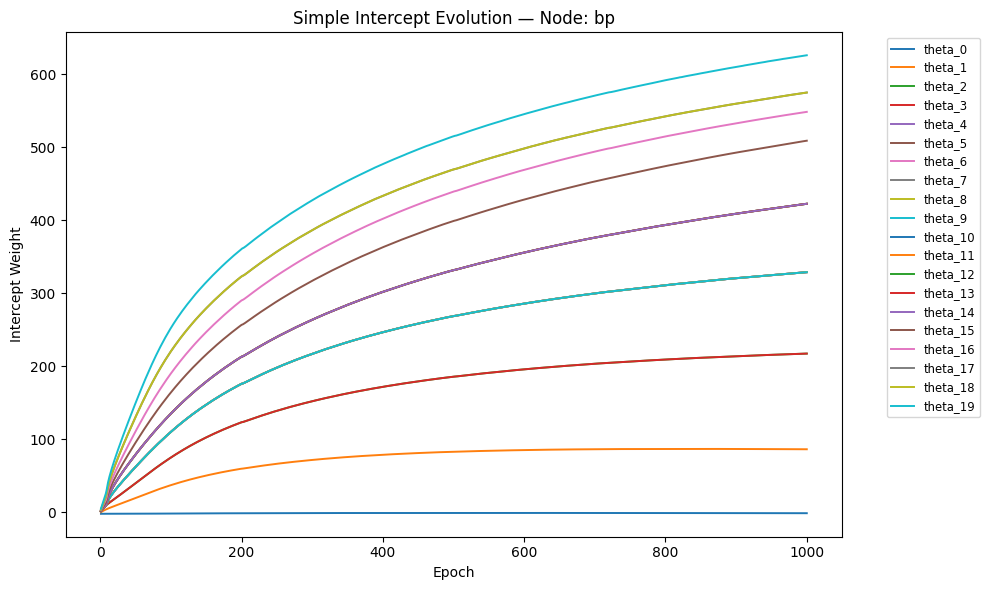

In [16]:
td_model.plot_simple_intercepts_history()

[WARNING] len(df)>1, function allows up to 5 rows to plot rest will be truncated, set: plot_n_rows accordingly
age: Simple intercept — identical h() for all samples.


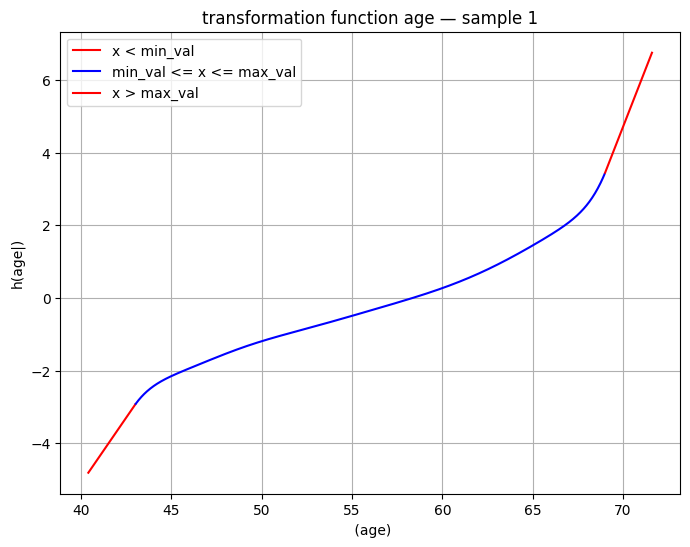

[WARNING] Node sex is not continuous, not implemented yet

=== Sample 1/1 ===
age           55.000000
sex            0.000000
exercise    2363.993947
lipid          2.931881
glucose       48.451310
bp           104.925718
Name: 75220, dtype: float64


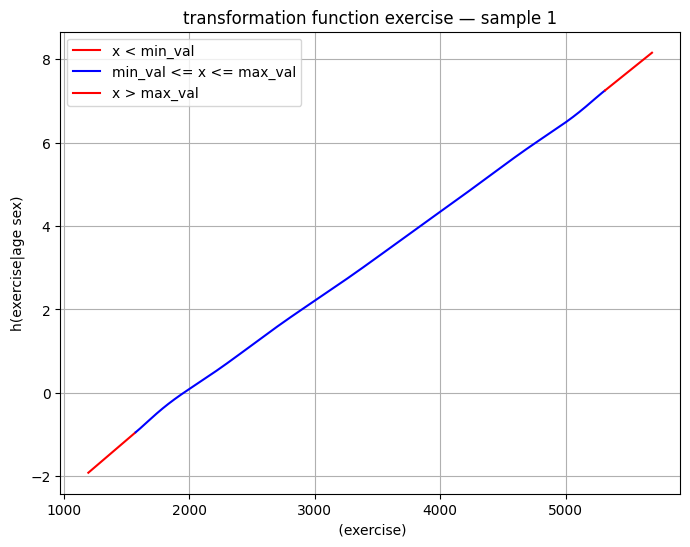


=== Sample 1/1 ===
age           55.000000
sex            0.000000
exercise    2363.993947
lipid          2.931881
glucose       48.451310
bp           104.925718
Name: 75220, dtype: float64


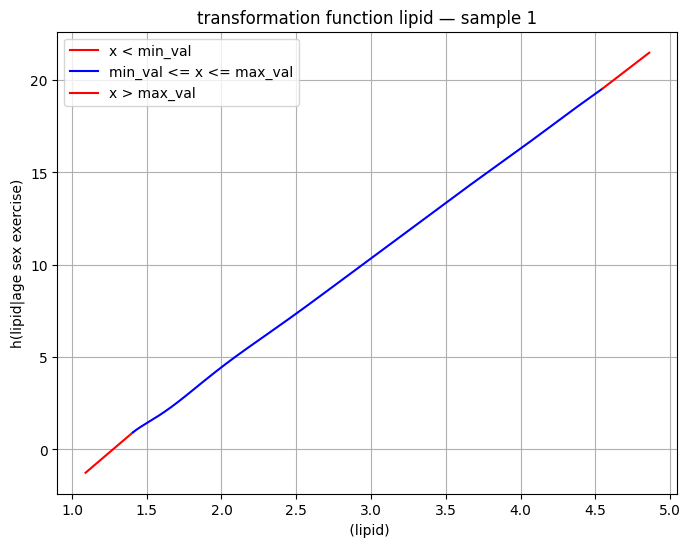


=== Sample 1/1 ===
age           55.000000
sex            0.000000
exercise    2363.993947
lipid          2.931881
glucose       48.451310
bp           104.925718
Name: 75220, dtype: float64


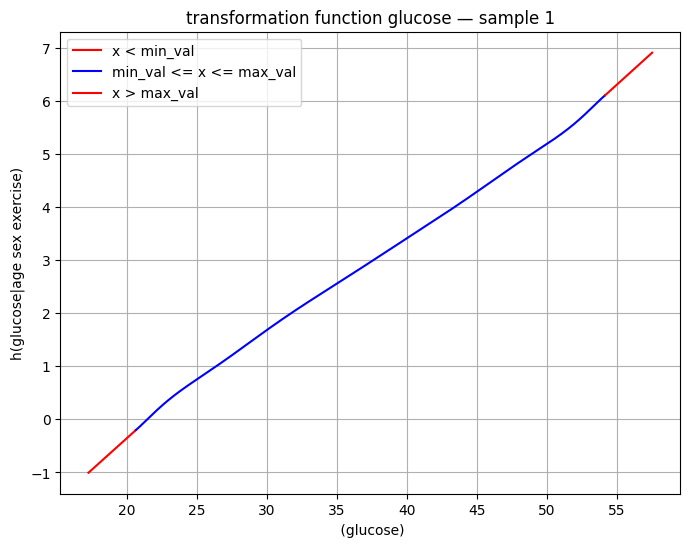


=== Sample 1/1 ===
age           55.000000
sex            0.000000
exercise    2363.993947
lipid          2.931881
glucose       48.451310
bp           104.925718
Name: 75220, dtype: float64


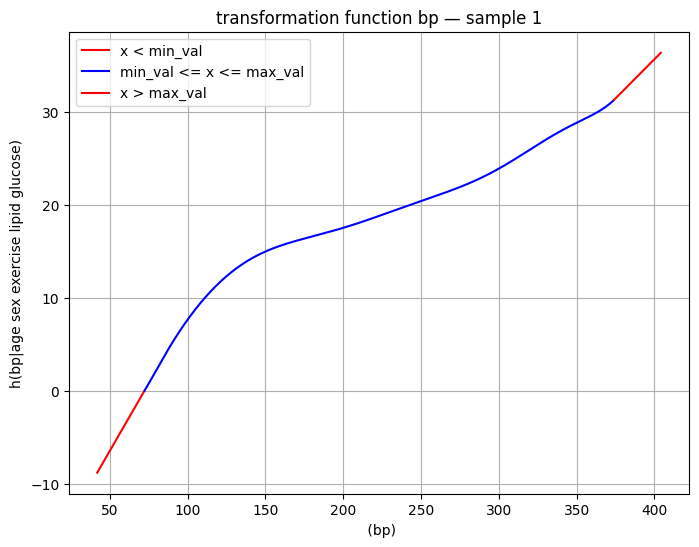

In [17]:
td_model.plot_hdag(train_df,plot_n_rows=1)

## Sampling

In [18]:
samples, latents = td_model.sample()

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Deleted directory: ukb/age/sampling
Deleted directory: ukb/sex/sampling
Deleted directory: ukb/exercise/sampling
Deleted directory: ukb/lipid/sampling
Deleted directory: ukb/glucose/sampling
Deleted directory: ukb/bp/sampling

----*----------*-------------*--------Sample Node: age ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node age from standard logistic distribution
[INFO] Loaded best model weights for node 'age' from ukb/age/best_model.pt
[WARNING] target_col 'age' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 48.94it/s]

[INFO] Completed sampling for node 'age'

----*----------*-------------*--------Sample Node: sex ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node sex from standard logistic distribution
[INFO] Loaded best model weights for node 'sex' from ukb/sex/best_model.pt
[WARNING] target_col 'sex' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'sex'

----*----------*-------------*--------Sample Node: exercise ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node exercise from standard logistic distribution
[INFO] Loaded best model weights for node 'exercise' from ukb/exercise/best_model.pt
[WARNING] target_col 'exercise' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 50.96it/s]

[INFO] Completed sampling for node 'exercise'

----*----------*-------------*--------Sample Node: lipid ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node lipid from standard logistic distribution
[INFO] Loaded best model weights for node 'lipid' from ukb/lipid/best_model.pt
[WARNING] target_col 'lipid' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 48.55it/s]

[INFO] Completed sampling for node 'lipid'

----*----------*-------------*--------Sample Node: glucose ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node glucose from standard logistic distribution
[INFO] Loaded best model weights for node 'glucose' from ukb/glucose/best_model.pt
[WARNING] target_col 'glucose' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 50.12it/s]

[INFO] Completed sampling for node 'glucose'

----*----------*-------------*--------Sample Node: bp ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node bp from standard logistic distribution
[INFO] Loaded best model weights for node 'bp' from ukb/bp/best_model.pt
[WARNING] target_col 'bp' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.32it/s]

[INFO] Completed sampling for node 'bp'
[INFO] DAG sampling completed successfully for all nodes.


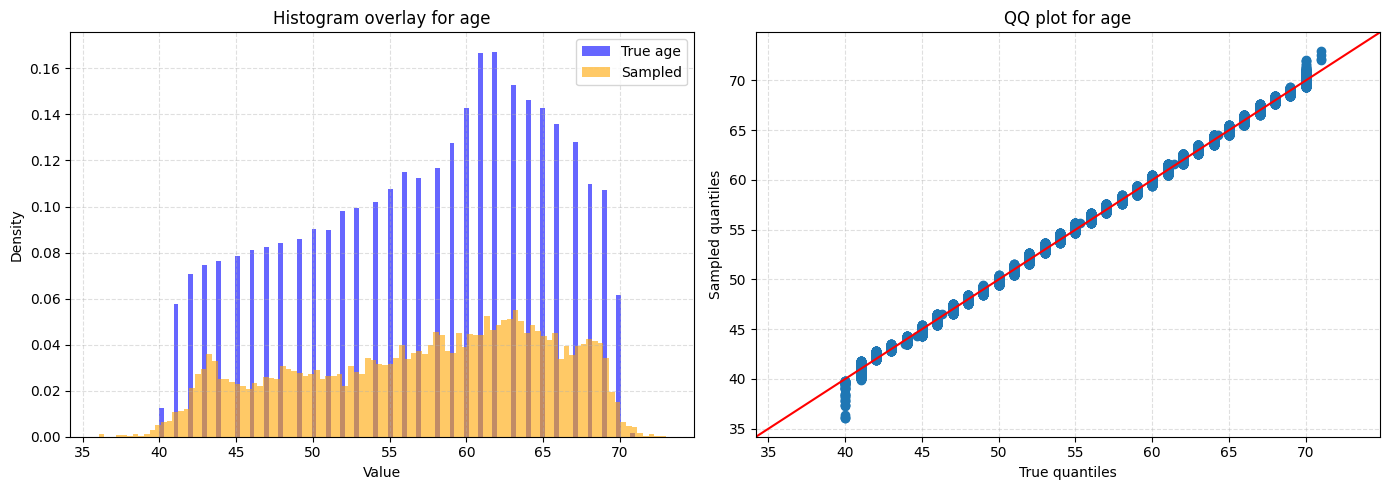

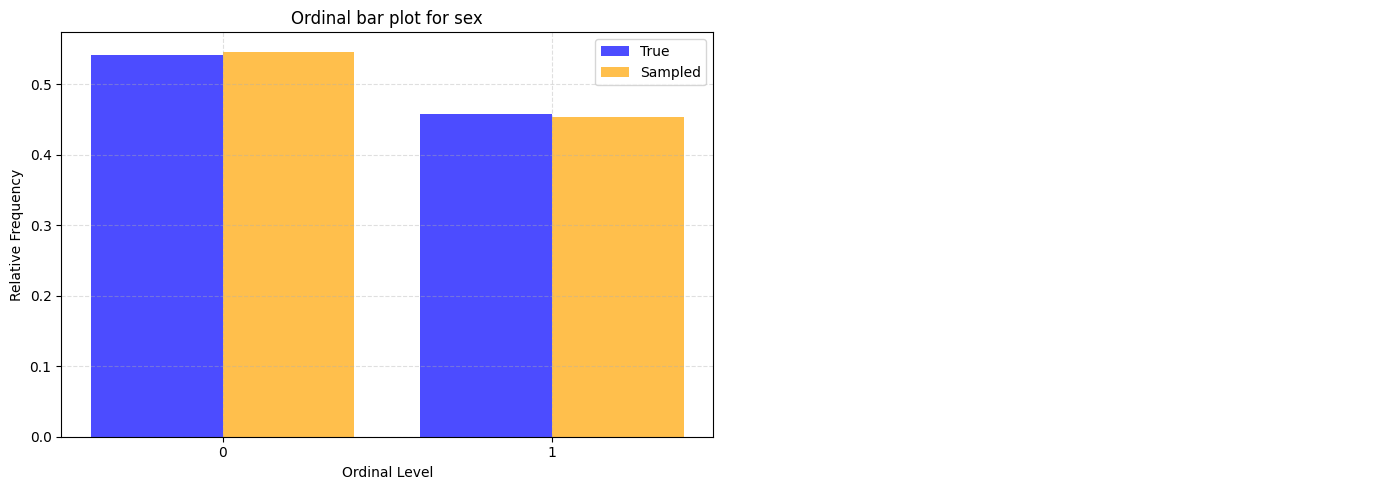

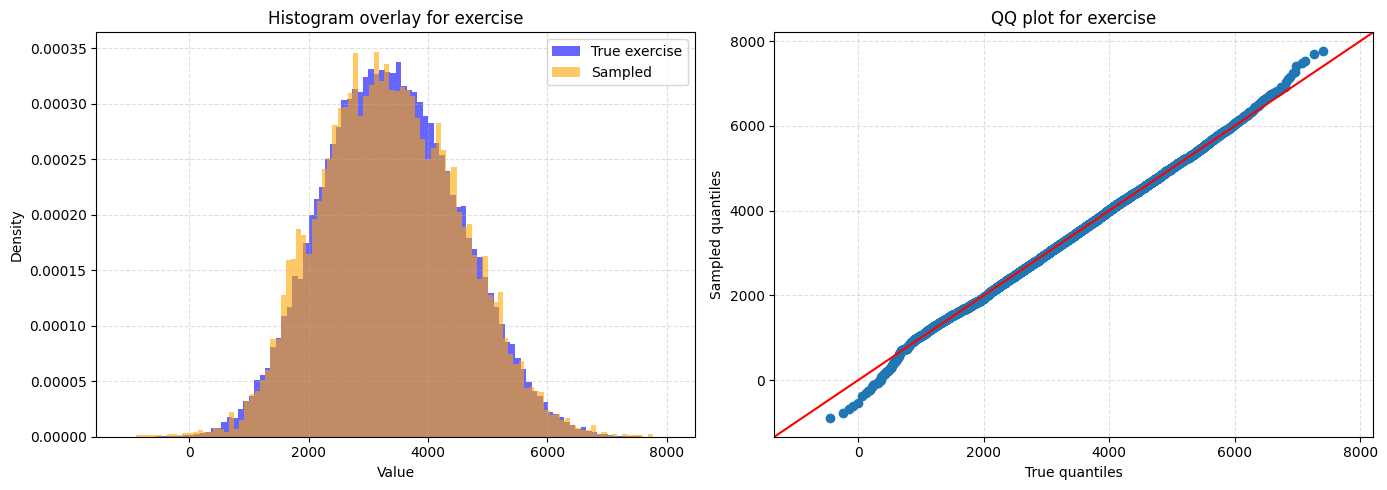

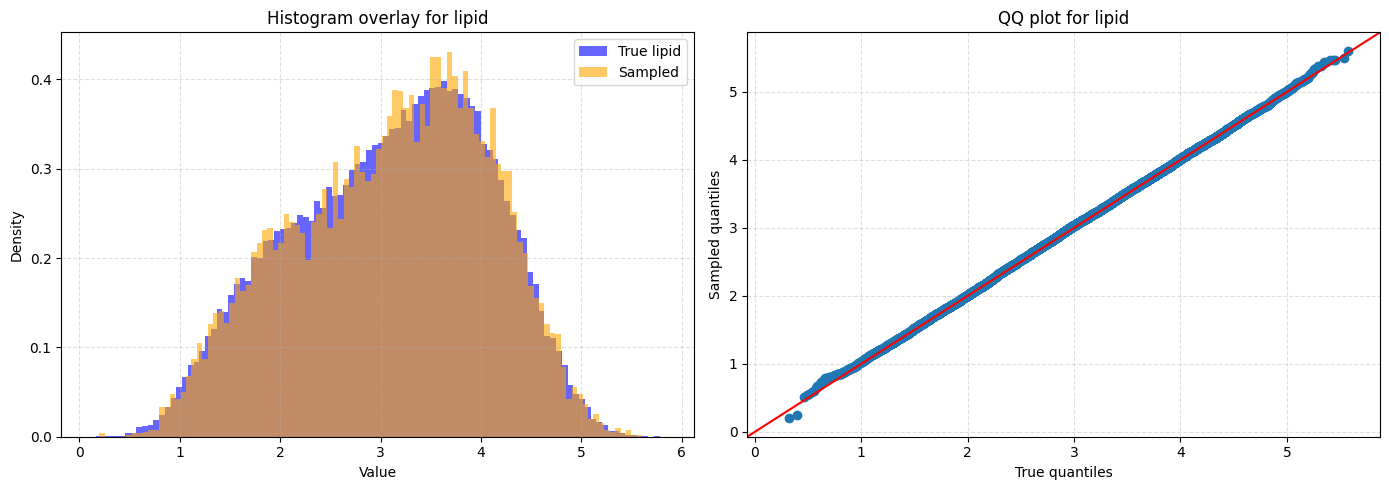

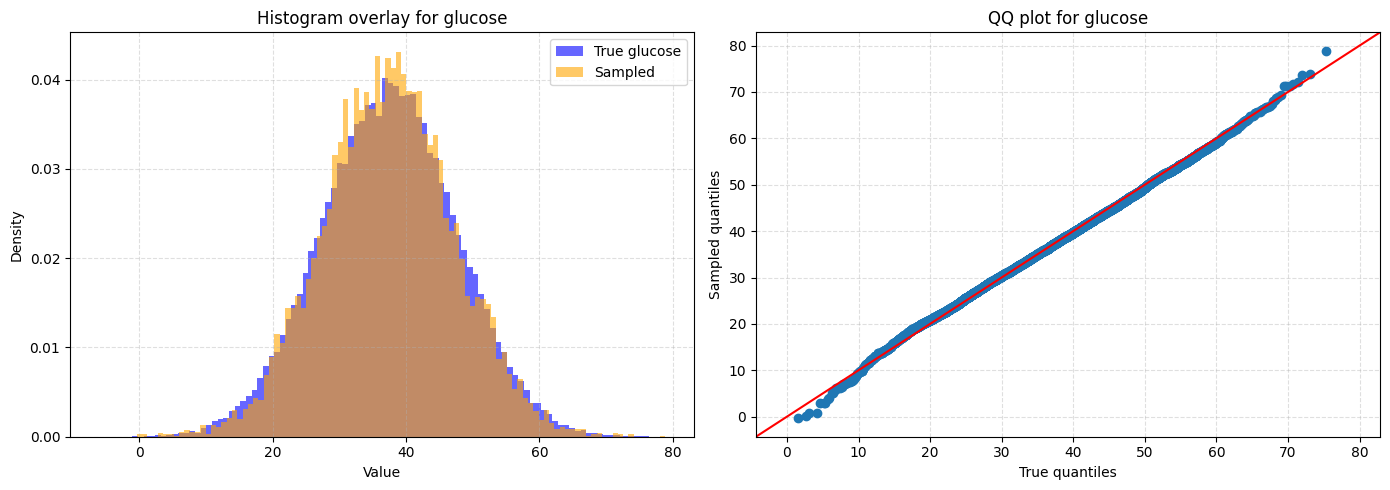

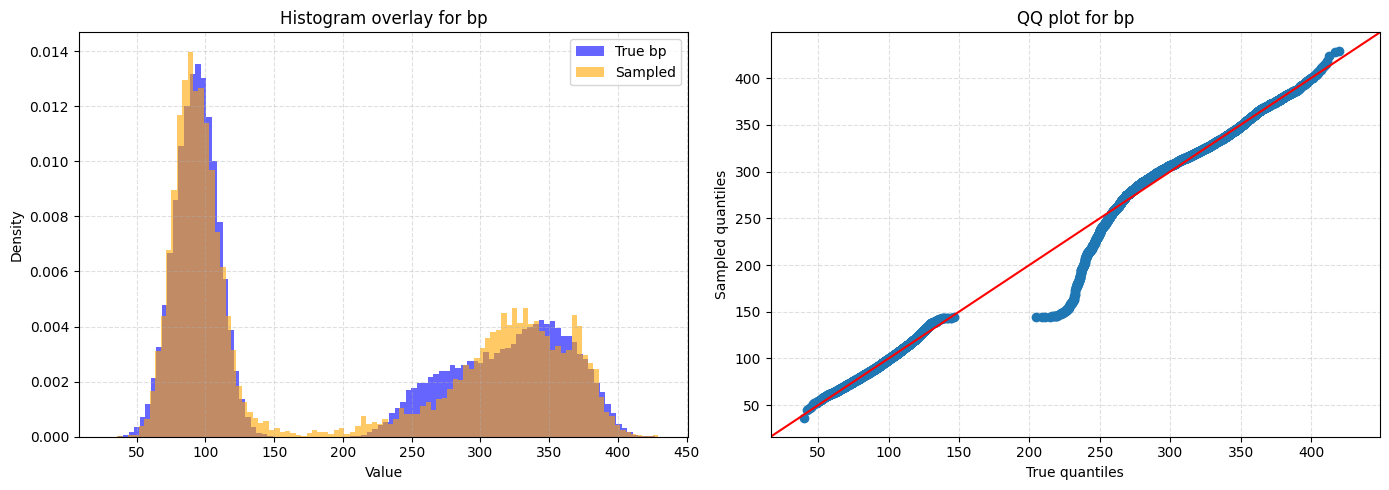

In [19]:
td_model.plot_samples_vs_true(df=train_df, sampled=samples)

## ATE

ATE=−0.005×(12000−2000)=−0.005×10000=−50

In [20]:
# TODO
# Totale Treatment effect


# average treatment effect of exercise on blood pressure

In [52]:
n = 1_000_000
low_exercise_df = simulate_dag(n_obs=n, doX={'exercise': 2000}, seed=0)
high_exercise_df = simulate_dag(n_obs=n, doX={'exercise': 12000}, seed=1)

ATE_empirical = high_exercise_df['bp'].mean() - low_exercise_df['bp'].mean()
MTE = high_exercise_df['bp'].median() - low_exercise_df['bp'].median()



np.float64(-64.14109755715654)

In [37]:
# lipid = -2.5 + 0.5*sex + 0.1*age - 0.0001*exercise + ε₁

# glucose = 35 + 2*sex + 0.1*age - 0.03*age*sex - 0.001*exercise + ε₂

# bp = 60 + 5*sex*0.8*age + 1.1*glucose + 3*lipid - 0.005*exercise + ε₃

#d exercise/d bp​=−0.005−0.0003−0.0011=−0.0064


# ATE=−0.0064×(12000−2000)=−0.0064×10000=−64
0.0064*(10_000)


64.0

In [53]:
torch.median(samples_ex_12000['bp'])-torch.median(samples_ex_2000['bp'])

tensor(-44.3092)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['exercise']
[INFO] Deleting all previously sampled data.
Deleted directory: ukb/age/sampling
Deleted directory: ukb/sex/sampling
Deleted directory: ukb/exercise/sampling
Deleted directory: ukb/lipid/sampling
Deleted directory: ukb/glucose/sampling
Deleted directory: ukb/bp/sampling

----*----------*-------------*--------Sample Node: age ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node age from standard logistic distribution
[INFO] Loaded best model weights for node 'age' from ukb/age/best_model.pt
[WARNING] target_col 'age' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 50.64it/s]

[INFO] Completed sampling for node 'age'

----*----------*-------------*--------Sample Node: sex ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node sex from standard logistic distribution
[INFO] Loaded best model weights for node 'sex' from ukb/sex/best_model.pt
[WARNING] target_col 'sex' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'sex'

----*----------*-------------*--------Sample Node: exercise ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'exercise' with value 12000
[INFO] Interventional data for node exercise is saved

----*----------*-------------*--------Sample Node: lipid ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node lipid from standard logistic distribution
[INFO] Loaded best model weights for node 'lipid' from ukb/lipid/best_model.pt
[WARNING] target_col 'lipid' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 45.85it/s]

[INFO] Completed sampling for node 'lipid'

----*----------*-------------*--------Sample Node: glucose ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node glucose from standard logistic distribution
[INFO] Loaded best model weights for node 'glucose' from ukb/glucose/best_model.pt
[WARNING] target_col 'glucose' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 46.57it/s]

[INFO] Completed sampling for node 'glucose'

----*----------*-------------*--------Sample Node: bp ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node bp from standard logistic distribution
[INFO] Loaded best model weights for node 'bp' from ukb/bp/best_model.pt
[WARNING] target_col 'bp' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 46.36it/s]


[INFO] Completed sampling for node 'bp'
[INFO] DAG sampling completed successfully for all nodes.


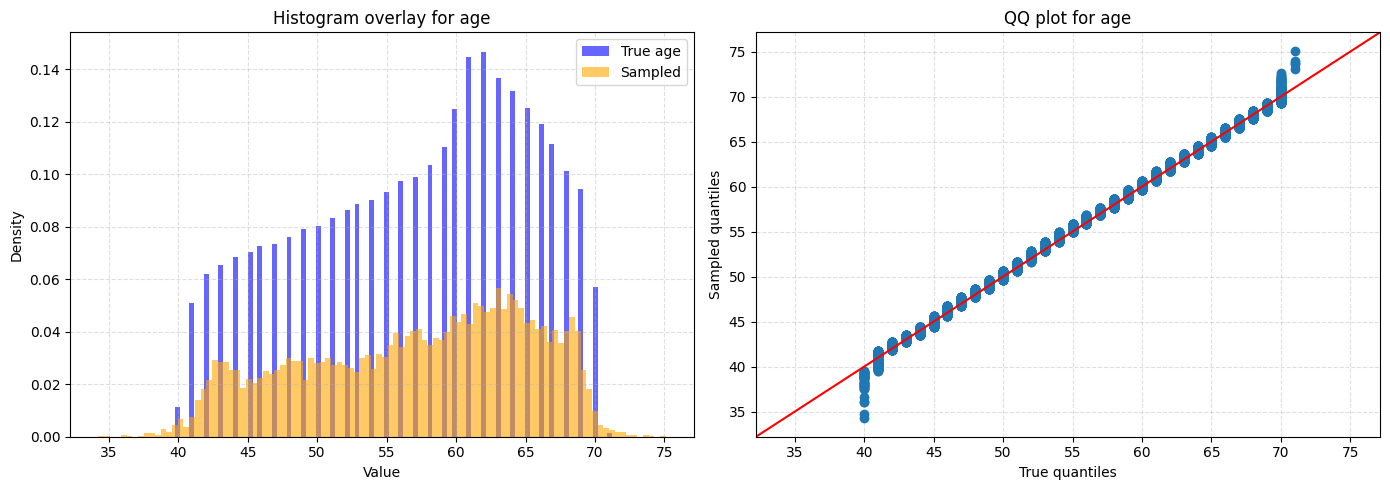

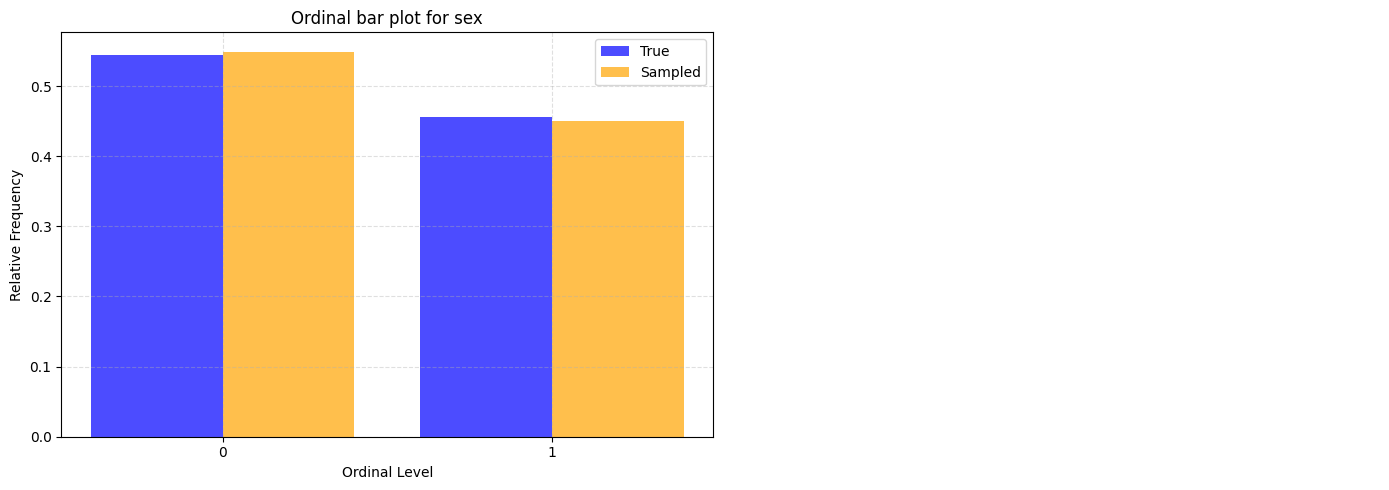

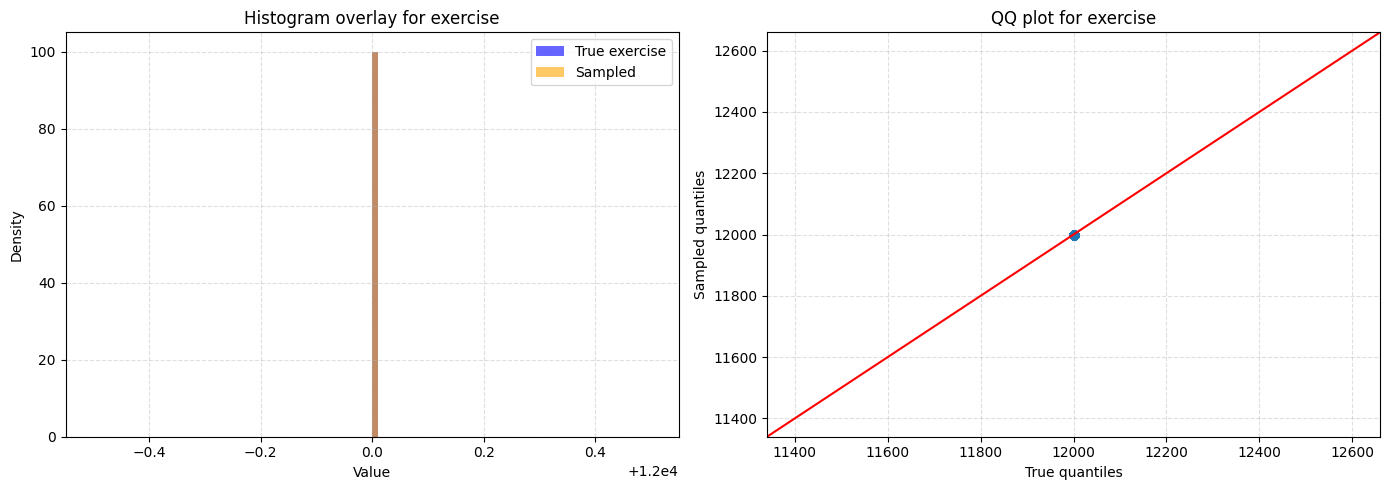

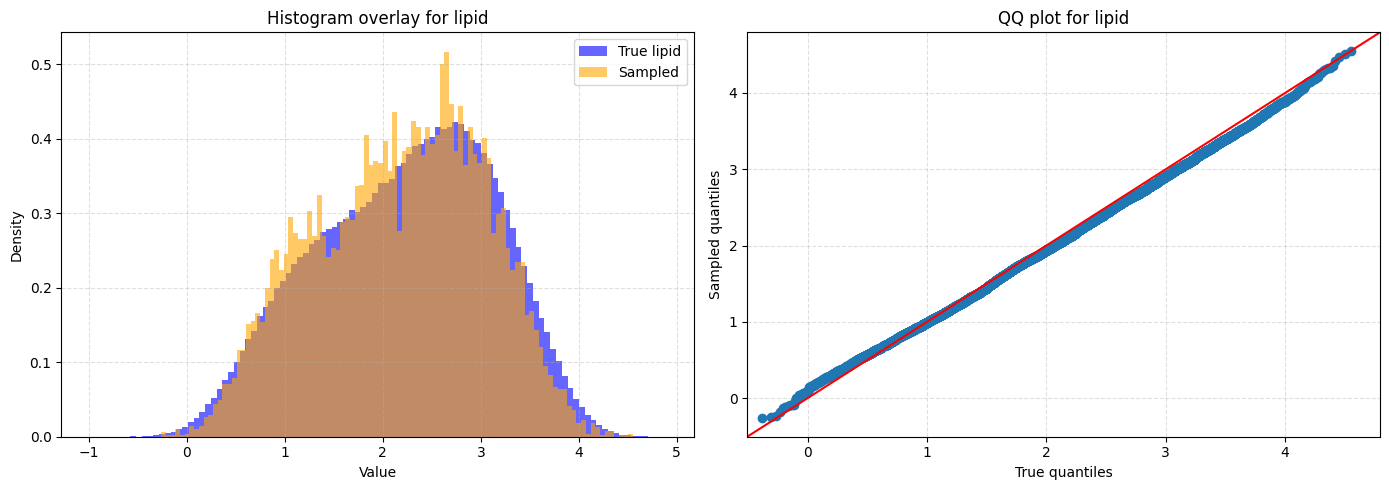

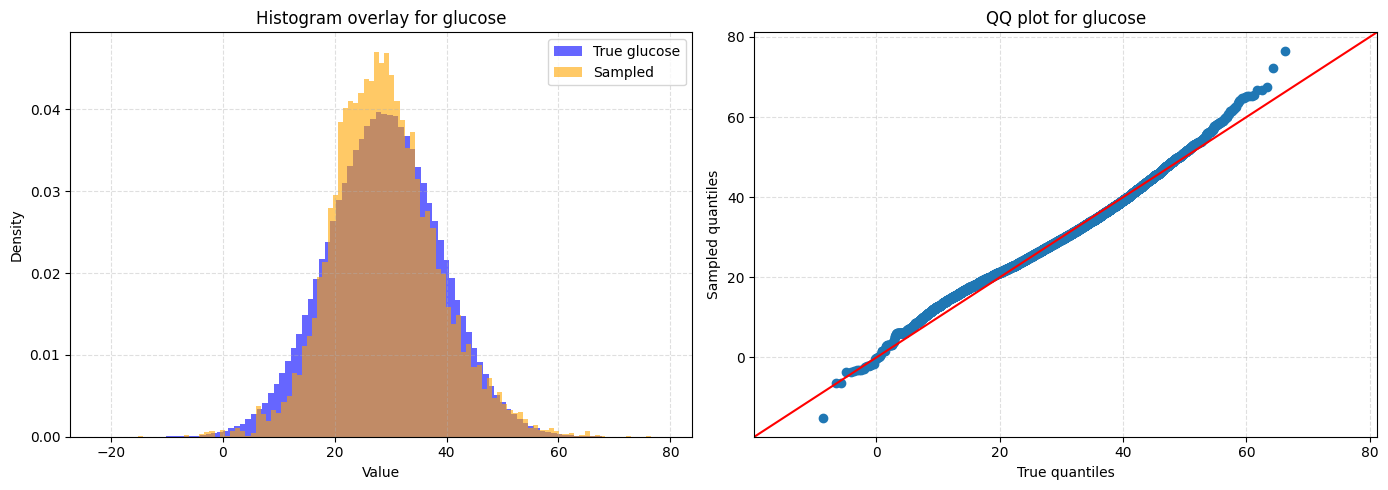

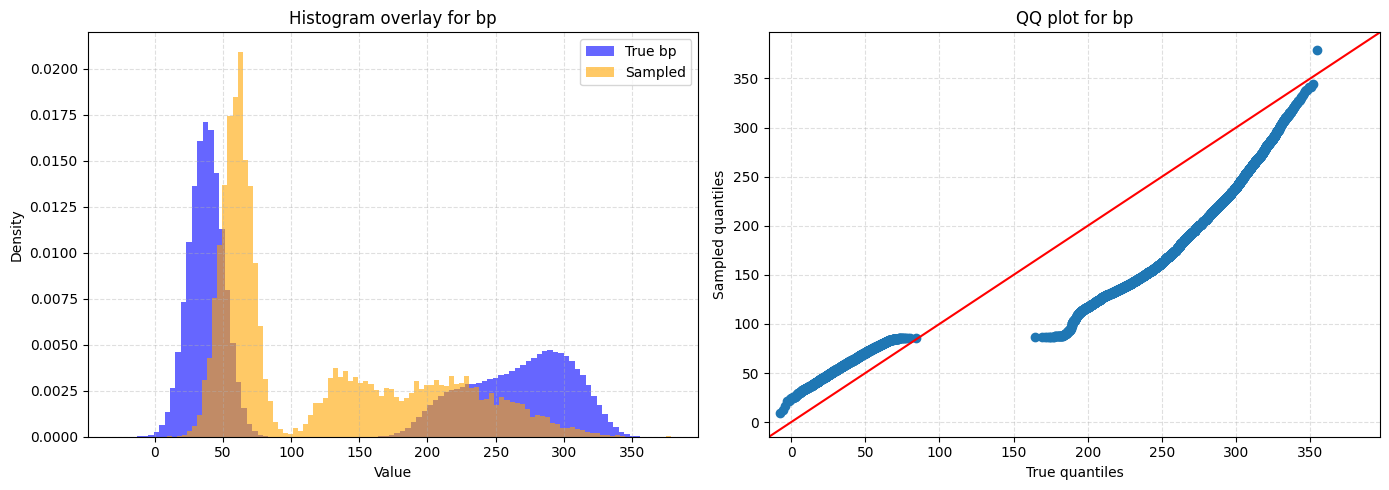

In [51]:
samples_ex_12000, _ = td_model.sample(do_interventions={'exercise':12000})
td_model.plot_samples_vs_true(df=high_exercise_df, sampled=samples_ex_12000)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['exercise']
[INFO] Deleting all previously sampled data.
Deleted directory: ukb/age/sampling
Deleted directory: ukb/sex/sampling
Deleted directory: ukb/exercise/sampling
Deleted directory: ukb/lipid/sampling
Deleted directory: ukb/glucose/sampling
Deleted directory: ukb/bp/sampling

----*----------*-------------*--------Sample Node: age ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node age from standard logistic distribution
[INFO] Loaded best model weights for node 'age' from ukb/age/best_model.pt
[WARNING] target_col 'age' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 47.28it/s]

[INFO] Completed sampling for node 'age'

----*----------*-------------*--------Sample Node: sex ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node sex from standard logistic distribution
[INFO] Loaded best model weights for node 'sex' from ukb/sex/best_model.pt
[WARNING] target_col 'sex' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'sex'

----*----------*-------------*--------Sample Node: exercise ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'exercise' with value 2000
[INFO] Interventional data for node exercise is saved

----*----------*-------------*--------Sample Node: lipid ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node lipid from standard logistic distribution
[INFO] Loaded best model weights for node 'lipid' from ukb/lipid/best_model.pt
[WARNING] target_col 'lipid' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 49.00it/s]

[INFO] Completed sampling for node 'lipid'

----*----------*-------------*--------Sample Node: glucose ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node glucose from standard logistic distribution
[INFO] Loaded best model weights for node 'glucose' from ukb/glucose/best_model.pt
[WARNING] target_col 'glucose' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 48.15it/s]

[INFO] Completed sampling for node 'glucose'

----*----------*-------------*--------Sample Node: bp ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node bp from standard logistic distribution
[INFO] Loaded best model weights for node 'bp' from ukb/bp/best_model.pt
[WARNING] target_col 'bp' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 51.43it/s]


[INFO] Completed sampling for node 'bp'
[INFO] DAG sampling completed successfully for all nodes.


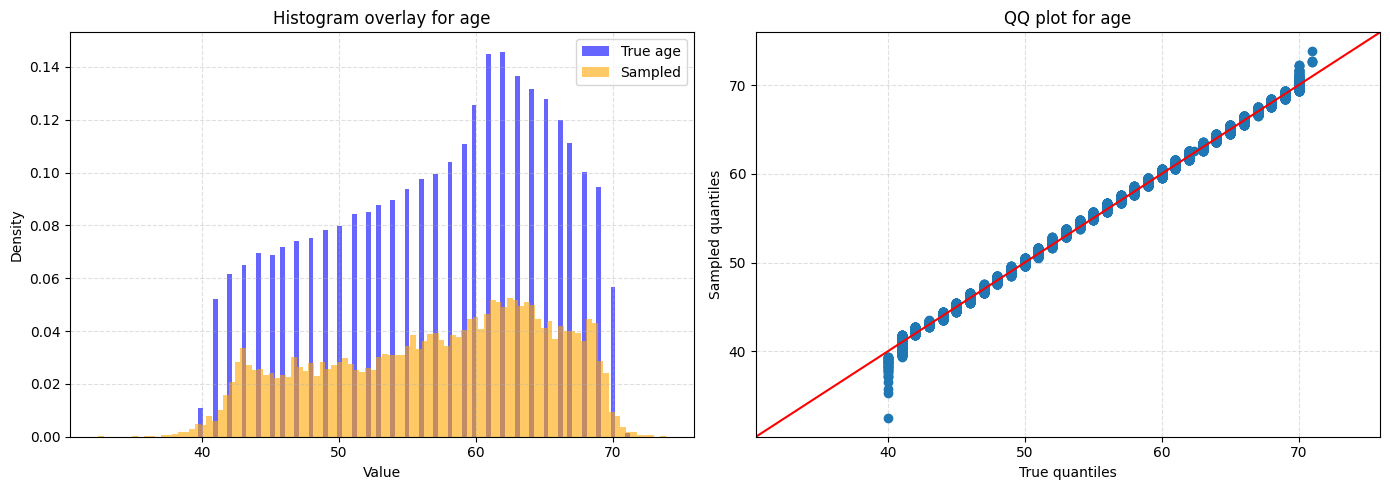

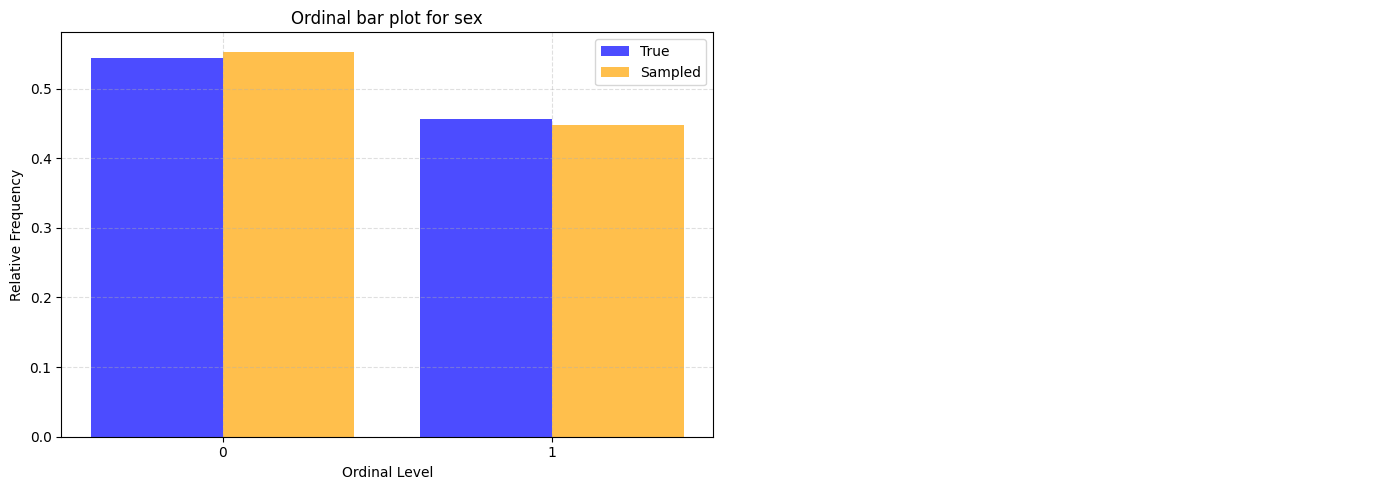

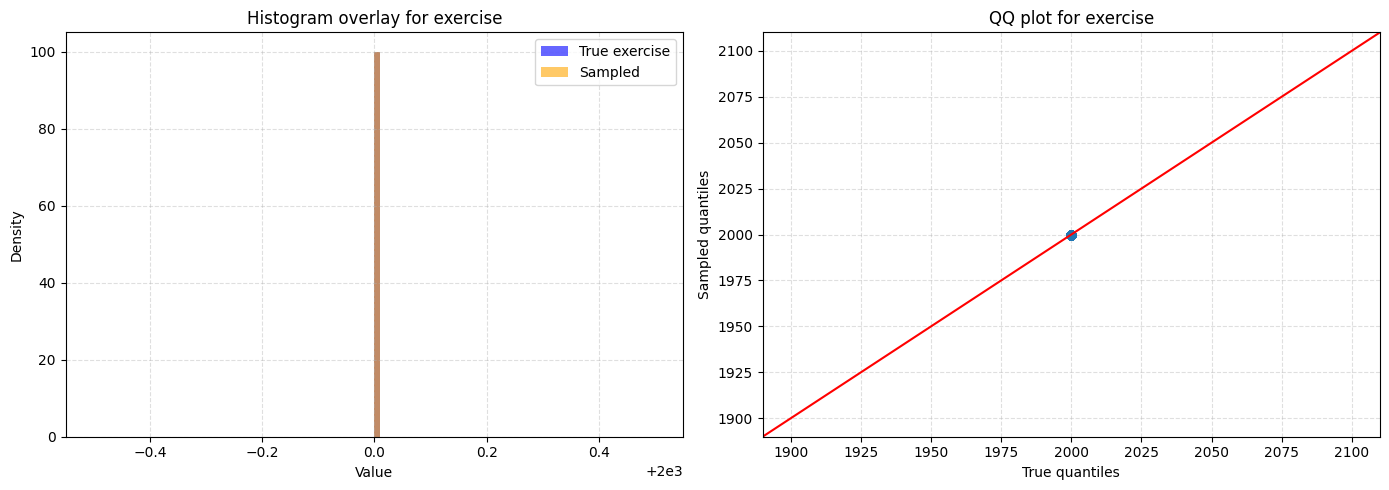

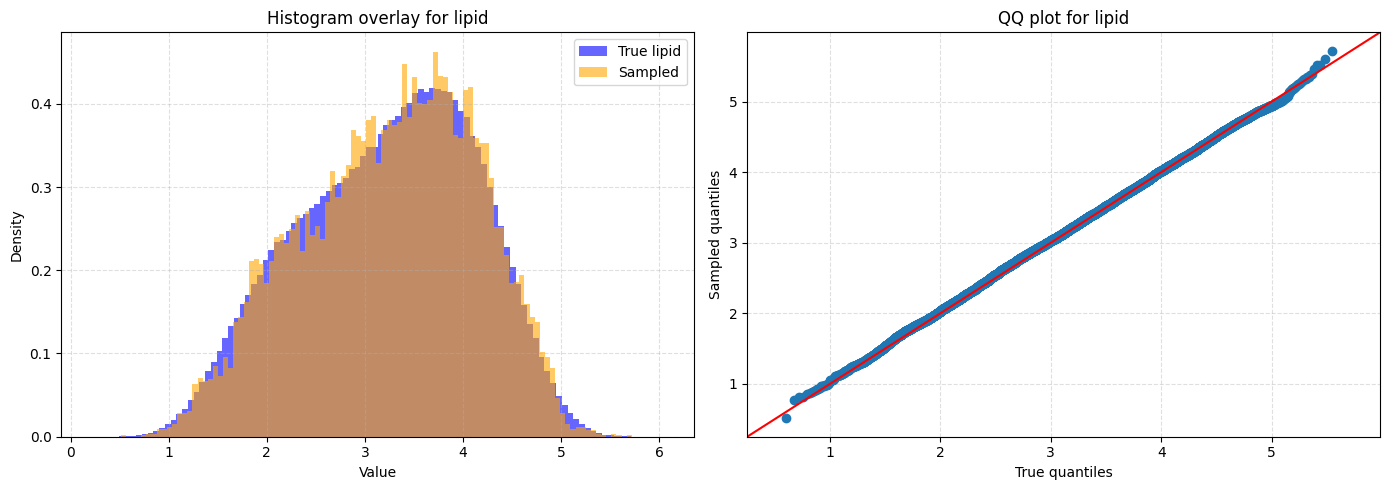

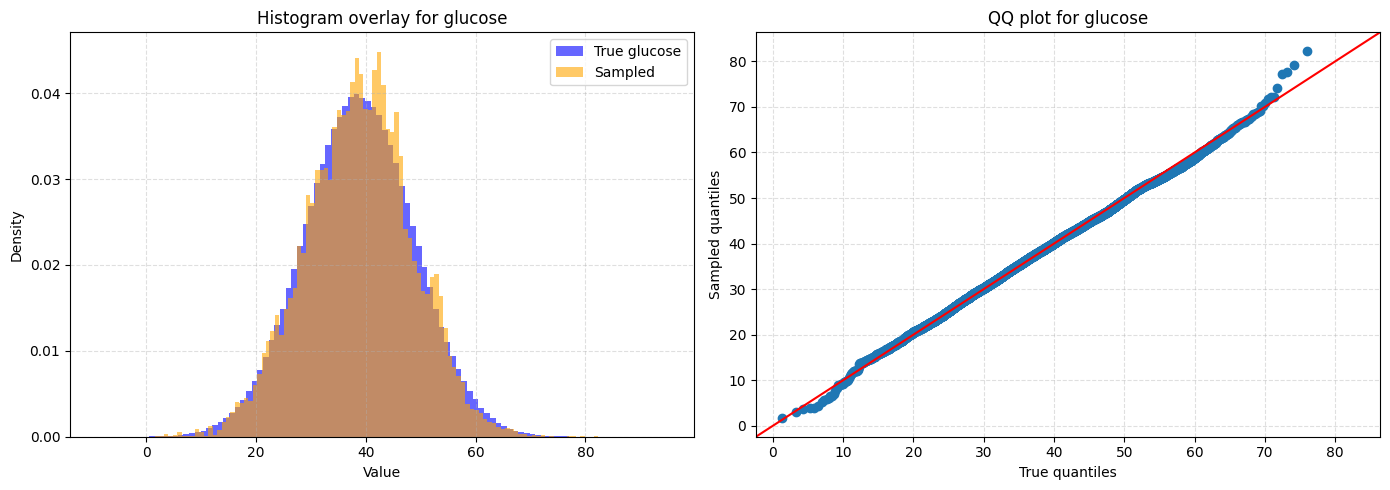

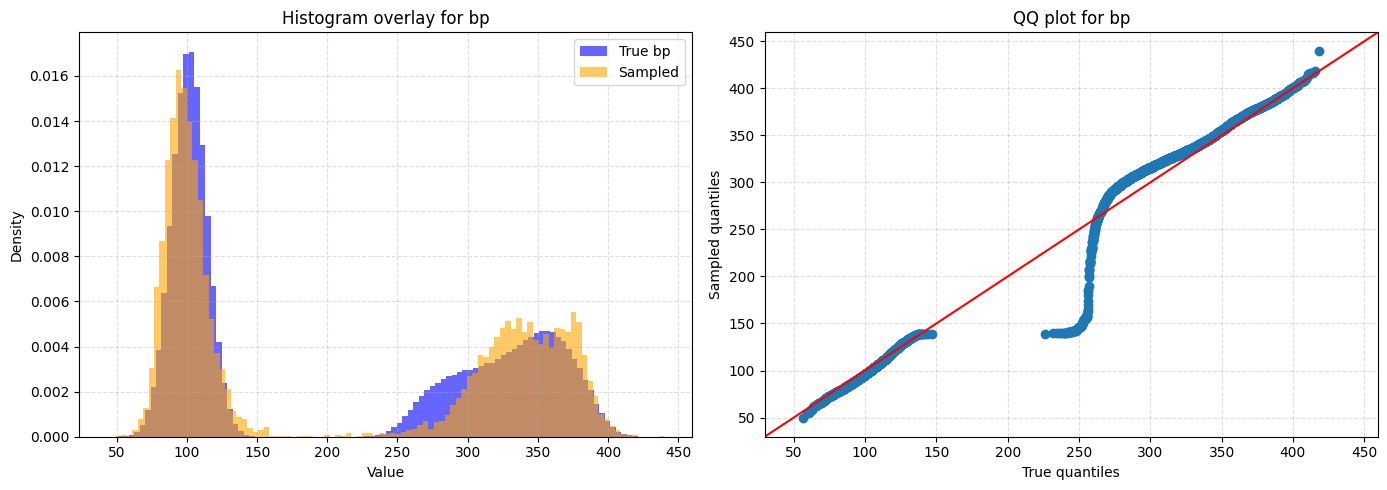

In [40]:
samples_ex_2000, _ = td_model.sample(do_interventions={'exercise':2000})
td_model.plot_samples_vs_true(df=low_exercise_df, sampled=samples_ex_2000)

